<a href="https://colab.research.google.com/github/lhyochan7/MRI-analysis/blob/main/3D_MRI_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patchify
import nibabel as nib
import tensorflow as tf
import numpy as np
import os

from patchify import patchify, unpatchify
from matplotlib import pyplot as plt
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv3D
from keras.layers import Conv3DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits.mplot3d import Axes3D 
import mpl_toolkits.mplot3d.art3d as art3d

In [ ]:
org_img = nib.load("/content/drive/MyDrive/Data/Original/ADNI_002_S_0685_2006_result.nii.gz")
tar_img = nib.load("/content/drive/MyDrive/Data/Target/ADNI_002_S_0685_2009_result.nii.gz")



In [ ]:
dataset = []



data1 = org_img.get_fdata()
data2 = tar_img.get_fdata()

comb_data = np.concatenate((data1,data2))
print(data1.dtype)
print(data2.shape)

print("comb_data: ", comb_data.shape)

org_data, tar_data = np.split(comb_data, 2, axis=0)

print("data1: ",data1.shape)
print("data2: ",data2.shape)

float64
(160, 192, 160)
comb_data:  (320, 192, 160)
data1:  (160, 192, 160)
data2:  (160, 192, 160)


In [ ]:
src_patches = patchify(org_data, (64,64,64), step = 32)
target_patches = patchify(tar_data, (64,64,64), step = 32)

(80, 64, 64, 64, 1)
<dtype: 'float32'>


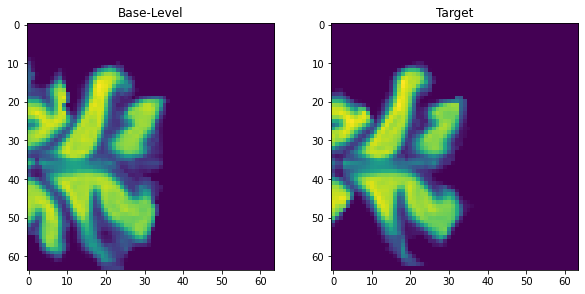

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Base-Level')
ax1.imshow(src_patches[1,2,3,:,:,32])


ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Target')
ax2.imshow(target_patches[1,2,3,:,:,32])


# combine vectors 4 x 5 x 4 to 80 patches
input_img = np.reshape(src_patches, (-1, src_patches.shape[3], src_patches.shape[4], src_patches.shape[5], 1)) # n_patches, x, y, z

# convert numpy to tensor
input_img = tf.convert_to_tensor(input_img, np.float32)
print(input_img.shape)
print(input_img.dtype)

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv3D(64, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv3D(128, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv3D(256, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv3D(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
  
	# second last output layer
	d = Conv3D(512, (3,3,3), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv3D(1, (3,3,3), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv3D(n_filters, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv3DTranspose(n_filters, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
  #image_shape = tf.convert_to_tensor(image_shape, np.float32)
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	
	# bottleneck, no batch norm and relu
	b = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(e5)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e5, 512)
	d2 = decoder_block(d1, e4, 512)
	d3 = decoder_block(d2, e3, 256)
	d4 = decoder_block(d3, e2, 128, dropout=False)
	d5 = decoder_block(d4, e1, 64, dropout=False)

	# output
	g = Conv3DTranspose(1, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d5)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model


g_model = define_generator((input_img.shape[1:]))
tf.keras.utils.plot_model(g_model, show_shapes=True, show_layer_names=True)

d_model = define_discriminator((input_img.shape[1:]))
tf.keras.utils.plot_model(d_model, show_shapes=True, show_layer_names=True)

gan_model = define_gan(g_model, d_model, input_img.shape[1:])
tf.keras.utils.plot_model(gan_model, show_shapes=True, show_layer_names=True)
gan_model.summary()



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
model_11 (Functional)           (None, 64, 64, 64, 1 59043521    input_34[0][0]                   
__________________________________________________________________________________________________
model_12 (Functional)           (None, 4, 4, 4, 1)   11747137    input_34[0][0]                   
                                                                 model_11[0][0]                   
Total params: 70,790,658
Trainable params: 59,040,577
Non-trainable params: 11,750,081
__________________________________________________________________________________________________


In [139]:
#def u_net_bn3d_mi(x,y,is_train=False,reuse=False,is_refine=False):
def define_generator(image_shape):

  '''
  w_init = tf.keras.initializers.TruncatedNormal(stddev=0.01)
  b_init = tf.constant_initializer(value=0.0)
  gamma_init = tf.random_normal_initializer(1., 0.02)
  df_dim=64
  v=y[:,np.newaxis,np.newaxis,np.newaxis,:]
  '''

  init = RandomNormal(stddev=0.02)
  df_dim = 64

  #with tf.variable_scope("u_net3d_mi", reuse=reuse):
  #tl.layers.set_name_reuse(reuse)
  
  in_image = Input(shape=image_shape)
  print(in_image.shape)
  #inputs=tf.keras.layers.InputLayer(image_shape, name='input')

  print(in_image.shape)

  #inputs1=tl.layers.InputLayer(y,name='inputmi')
  conv1 = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(in_image)
  conv1 = BatchNormalization()(conv1, training=True)
  conv1 = LeakyReLU(alpha=0.2)(conv1)

  conv2 = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(conv1)
  conv2 = BatchNormalization()(conv2, training=True)
  conv2 = LeakyReLU(alpha=0.2)(conv2)

  conv3 = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(conv2)
  conv3 = BatchNormalization()(conv3, training=True)
  conv3 = LeakyReLU(alpha=0.2)(conv3)

  conv4 = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(conv3)
  conv4 = BatchNormalization()(conv4, training=True)
  conv4 = LeakyReLU(alpha=0.2)(conv4)

  conv5 = Conv3D(512, (4,4,4), strides=(8,8,8), padding='valid', kernel_initializer=init)(conv4)
  conv5 = BatchNormalization()(conv5, training=True)
  conv5 = LeakyReLU(alpha=0.2)(conv5)

  up5 = Conv3DTranspose(512, (4,4,4), strides=(2,2,2), padding='valid', kernel_initializer=init)(conv5) #originally (5,6,5) strides = (5,6,5)
  up5 = BatchNormalization()(up5, training=True)
 
  up4 = Concatenate([up5, conv4])
  up4 = Conv3DTranspose(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(up5)
  up4 = BatchNormalization()(up4, training=True)  
  up4 = LeakyReLU(alpha=0.2)(up4)

  up3 = Concatenate([up4, conv3])
  up3 = Conv3DTranspose(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(up4)
  up3 = BatchNormalization()(up3, training=True)  
  up3 = LeakyReLU(alpha=0.2)(up3)

  up2 = Concatenate([up3, conv2])
  up2 = Conv3DTranspose(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(up3)
  up2 = BatchNormalization()(up2, training=True)  
  up2 = LeakyReLU(alpha=0.2)(up2)

  up1 = Concatenate([up2, conv1])
  up1 = Conv3DTranspose(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(up2)
  up1 = BatchNormalization()(up1, training=True)  
  up1 = LeakyReLU(alpha=0.2)(up1)

  final = Conv3D(1, (1,1,1), strides=(1,1,1), padding='same', kernel_initializer=init)(up1)
  out_image = Activation('tanh')(final)
	# define model
  model = Model(in_image, out_image)  
  return model
  
  

print(input_img.shape[1:])
g_model = define_generator((input_img.shape[1:]))
tf.keras.utils.plot_model(g_model, show_shapes=True, show_layer_names=True)
g_model.summary()

(64, 64, 64, 1)
(None, 64, 64, 64, 1)
(None, 64, 64, 64, 1)
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 64, 64, 64, 1)]   0         
_________________________________________________________________
conv3d_181 (Conv3D)          (None, 32, 32, 32, 64)    4160      
_________________________________________________________________
batch_normalization_275 (Bat (None, 32, 32, 32, 64)    256       
_________________________________________________________________
leaky_re_lu_242 (LeakyReLU)  (None, 32, 32, 32, 64)    0         
_________________________________________________________________
conv3d_182 (Conv3D)          (None, 16, 16, 16, 128)   524416    
_________________________________________________________________
batch_normalization_276 (Bat (None, 16, 16, 16, 128)   512       
________________________________________________________________

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y  # random pair of images with label class=1 to indicate real

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y   # generator output with label class=0 to indicate fake

def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1, n_patch=16):
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
  


#train(d_model, g_model, gan_model, input_img)

In [ ]:
print(src_patches.shape)

g_model = define_generator((input_img.shape[1:]))
d_model = define_discriminator((input_img.shape[1:]))

predicted_patches = []
for i in range(src_patches.shape[0]):
  for j in range(src_patches.shape[1]):
    for k in range(src_patches.shape[2]):
      #print(i,j,k)
      #real_patch = target_patches[i,j,k,:,:,:]  # (64,64,64)
      single_patch = src_patches[i,j,k, :,:,:]  # (64, 64, 64)
      #real_patch = np.reshape(real_patch, (-1, real_patch.shape[0], real_patch.shape[1], real_patch.shape[2], 1))

      single_patch = np.reshape(single_patch, (-1, single_patch.shape[0], single_patch.shape[1], single_patch.shape[2], 1))
      single_patch_pred = g_model.predict(single_patch)
      single_patch_pred_argmax = np.argmax(single_patch_pred, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_pred)


predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (src_patches.shape[0], src_patches.shape[1], src_patches.shape[2],
                                         src_patches.shape[3], src_patches.shape[4], src_patches.shape[5]) )
print(predicted_patches_reshaped.shape)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Original')
ax1.imshow(src_patches[1,2,3,:,:,38])


ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Predicted')
ax2.imshow(predicted_patches_reshaped[1,2,3,:,:,38])

In [ ]:
reconstructed_image = unpatchify(predicted_patches_reshaped, org_img.shape)
print(reconstructed_image.shape)

#print(reconstructed_image)

# to save this 3D (ndarry) numpy use this
#ni_img = nib.Nifti1Image(reconstructed_image, func.affine)

#nib.save(ni_img, 'output.nii.gz')

In [ ]:
def u_net_bn3d_mi(x,y,is_train=False,reuse=False,is_refine=False):

  w_init = tf.truncated_normal_initializer(stddev=0.01)
  b_init = tf.constant_initializer(value=0.0)
  gamma_init = tf.random_normal_initializer(1., 0.02)
  df_dim=64
  v=y[:,np.newaxis,np.newaxis,np.newaxis,:]

  with tf.variable_scope("u_net3d_mi", reuse=reuse):
    tl.layers.set_name_reuse(reuse)
    inputs=tl.layers.InputLayer(x,name='input')
    inputs1=tl.layers.InputLayer(y,name='inputmi')
    conv1 = tl.layers.Conv3dLayer(inputs, shape=(4,4,4,1,df_dim), stride=(1,2,2,2,1), 
                                  padding='SAME', act=None, W_init=winit, b_init=b_init, name='conv1')
    conv1 = tl.layers.BatchNormLayer(conv1, act=lambda x:tl.act.lrelu(x, 0.2), 
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn1')

    conv2 = tl.layers.Conv3dLayer(conv1, shape=(4,4,4,df_dim,df_dim*2), stride=(1,2,2,2,1), 
                                  padding='SAME', act=None, W_init=winit, b_init=b_init, name='conv2')
    conv2 = tl.layers.BatchNormLayer(conv2, act=lambda x:tl.act.lrelu(x, 0.2), 
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn2')

    conv3 = tl.layers.Conv3dLayer(conv2, shape=(4,4,4,df_dim*2,df_dim*4), stride=(1,2,2,2,1), 
                                  padding='SAME', act=None, W_init=winit, b_init=b_init, name='conv3')
    conv3 = tl.layers.BatchNormLayer(conv3, act=lambda x:tl.act.lrelu(x, 0.2), 
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn3')

    conv4 = tl.layers.Conv3dLayer(conv3, shape=(4,4,4,df_dim*4,df_dim*8), stride=(1,2,2,2,1), 
                                  padding='SAME', act=None, W_init=winit, b_init=b_init, name='conv4')
    conv4 = tl.layers.BatchNormLayer(conv4, act=lambda x:tl.act.lrelu(x, 0.2), 
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn4')
    
    conv5 = tl.layers.Conv3dLayer(conv4, shape=(5,6,5,df_dim*8, 509), strides=(1,8,8,8,1), padding='VALID', act=None,
                                  W_init=w_init, b_init=b_init, name='conv5')
    
    conv5 = tl.layers.ConcatLayer([conv5, inputs1], concat_dim=4, name='concat6') # Concat multi-info

    conv5 = tl.layers.BatchNormLayer(conv5, act=lambda x: tl.act.lrelu(x,0.2),
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn5')
    
    up5 = tl.layers.DeConv3d(conv5, df_dim*8, (5,6,5), strides=(5,6,5), padding='VALID', act=None,
                             W_init=w_init, b_init=b_init, name='deconv5')
    up5 = tl.layers.BatchNormLayer(up5, act=tf.nn.relu, ls_train=ls_train,
                                   gamma_init=gamma_init, name='dbn5')
  
    up4 = tl.layers.ConcatLayer([up5, con4], concat_dim=4, name='concat4')
    up4 = tl.layers.DeConv3d(up4, df_dim*8, (4,4,4), strides=(2,2,2), padding='SAME', act=None,
                             W_init=w_init, b_init=b_init, name='deconv4')
    up4 = tl.layers.BatchNormLayer(up5, act=tf.nn.relu, ls_train=ls_t4ain,
                                   gamma_init=gamma_init, name='dbn4')
  
    up3 = tl.layers.ConcatLayer([up4, con3], concat_dim=4, name='concat3')
    up3 = tl.layers.DeConv3d(up4, df_dim*4, (4,4,4), strides=(2,2,2), padding='SAME', act=None,
                             W_init=w_init, b_init=b_init, name='deconv3')
    up3 = tl.layers.BatchNormLayer(up5, act=tf.nn.relu, ls_train=ls_t4ain,
                                   gamma_init=gamma_init, name='dbn3')
  
    up2 = tl.layers.ConcatLayer([up3, con2], concat_dim=4, name='concat2')
    up2 = tl.layers.DeConv3d(up4, df_dim*2, (4,4,4), strides=(2,2,2), padding='SAME', act=None,
                             W_init=w_init, b_init=b_init, name='deconv2')
    up2 = tl.layers.BatchNormLayer(up5, act=tf.nn.relu, ls_train=ls_t4ain,
                                   gamma_init=gamma_init, name='dbn2')
  
    up1 = tl.layers.ConcatLayer([up2, con1], concat_dim=4, name='concat1')
    up1 = tl.layers.DeConv3d(up1, 64,(4,4,4), strides=(2,2,2), padding='SAME', act=None,
                             W_init=w_init, b_init=b_init, name='deconv1')
     
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary() 

    